# Mixed Constraints: The Population Transport in France

This notebook builds a **grid-based population dataset** for a *chosen French department* and performs an **optimal transport (OT)** interpolation between two population snapshots using **mixed constraints**.  
It generalizes a prototype built for Ain (01) so you can re-run it for *any* department (e.g. `75`, `59`, `2A`, `2B`, `974`, …).

**What you’ll do:**
1. Configure paths to the Admin Express GPKG and the historical population Excel.
2. Choose the **department code** and years of interest.
3. Build a polygon-aware **grid** and a **barrier mask** (cells outside the department are forbidden).
4. Convert commune-level counts to a grid via a **cell–commune area-fraction matrix**.
5. (Optional) apply a very light Gaussian smoothing that preserves mass.
6. Save a compact `.npz` bundle and run **OT interpolation** with your solver.
7. Plot comparisons (**X_true** vs **X_ot**) and export a paper-ready figure.

**Good to know**
- CRS: All geometry is handled in **Lambert‑93** (`EPSG:2154`).
- The grid resolution `N×N` controls both speed and memory. Start with **N=64**.
- The mixed-constraint setup mirrors the earlier scaffold: a **spatial barrier** and a **mass budget** over time.

## Requirements

- Python 3.9+
- `numpy`, `pandas`, `geopandas`, `fiona`, `shapely`
- Optional (recommended for speed/smoothing): `scipy`
- **Data**
  - **Admin Express GPKG** (e.g. `ADE_4-0_GPKG_WGS84G_FRA-ED2025-08-15.gpkg`)
  - **Historical population Excel** with columns like `DEP`, `CODGEO`, `LIBGEO`, `pop<year>` (e.g. `pop1876`, `pop1881`, …)

> Tip: On some systems `geopandas` may require system libraries (GEOS/PROJ/GDAL). Install via `conda-forge` for a smoother experience.

In [1]:
# --- Configuration ---
import os

# Input data paths (edit these for your machine)
EXCEL = "data/input/base-pop-historiques-1876-2020.xlsx"
GPKG  = "data/input/ADE_4-0_GPKG_WGS84G_FRA-ED2025-08-15.gpkg"

# Choose the department (examples: "01" Ain, "75" Paris, "2A" Corse-du-Sud, "2B" Haute-Corse, "20" for both Corsican deps)
DEP_CODE = "31"
# Ain: 01
# Puy-de-Dôme: 63
# Haute-Garonne: 31

# Years to rasterize (columns must exist in the Excel as pop<year>)
YEARS = sorted(list(range(1876, 1912, 5)) + [1936, 1931, 1926, 1921])

TARGET_CRS = "EPSG:2154"
N = 64   # grid size (N x N). Increase carefully for higher detail.
os.makedirs("data/output", exist_ok=True)

print(f"Using department: {DEP_CODE}, grid: {N}×{N}")

Using department: 31, grid: 64×64


In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import fiona
from shapely.geometry import box

# Optional (faster sparse ops & small Gaussian smoothing)
try:
    from scipy.sparse import coo_matrix, csr_matrix
    from scipy.ndimage import gaussian_filter
    SCIPY = True
except Exception:
    SCIPY = False
print("SciPy available:", SCIPY)

SciPy available: True


## A. Utility functions

Robust helpers to:
- Find the right layer names inside the GPKG.
- Detect the appropriate columns for INSEE codes and department codes.
- Load **communes** or **department boundary** for the chosen `DEP_CODE` (including edge cases like `2A/2B` or `20`).

In [3]:
def find_layer(path, candidates):
    """Return the first layer name present in `path` that matches any of `candidates` (case-insensitive)."""
    layers = fiona.listlayers(path)
    for cand in candidates:
        for L in layers:
            if L.lower() == cand.lower():
                return L
    return None

def first_col(gdf, candidates):
    """Return the first existing column among the `candidates`, else None."""
    for c in candidates:
        if c in gdf.columns:
            return c
    return None

def dep_prefixes(dep_code):
    """Return a tuple of prefixes that should match CODGEO/DEP codes for a requested department selector.

    Examples
    --------
    "01" -> ("01",)
    "2A" -> ("2A",)
    "20" -> ("2A","2B")    # treat '20' as 'both Corsican departments'
    "69" -> ("69",)        # will match 69, 69D, 69M when present
    """
    s = str(dep_code).upper()
    if s == "20":
        return ("2A", "2B")
    return (s,)

def load_communes_by_dep(gpkg, dep_code="01", target_crs="EPSG:2154"):
    """
    Load communes for the requested department (by prefix match on INSEE/CODGEO or explicit dep code column).
    Returns a GeoDataFrame with normalized 'CODGEO' column and requested CRS.
    """
    com_layer = find_layer(gpkg, ["COMMUNE","COMMUNES","commune","communes"])
    if not com_layer:
        raise RuntimeError("COMMUNE layer not found in the GPKG.")

    com = gpd.read_file(gpkg, layer=com_layer).to_crs(target_crs)

    # Normalize commune code column -> CODGEO (5-character string; may begin with '2A'/'2B')
    code_cols = ["CODGEO","codgeo","INSEE_COM","insee_com","INSEE","insee","code_insee","CODE_INSEE","id"]
    cc = first_col(com, code_cols)
    if cc is None:
        raise RuntimeError("No commune INSEE code column found in the COMMUNE layer.")
    com["CODGEO"] = com[cc].astype(str).str.upper().str.zfill(5)

    # Try direct department column if present (faster)
    dep_cols = ["code_dep","CODE_DEP","DEP","dep","INSEE_DEP","insee_dep"]
    dcol = first_col(com, dep_cols)

    prefs = dep_prefixes(dep_code)
    if dcol is not None:
        dep_vals = com[dcol].astype(str).str.upper()
        mask = False
        for p in prefs:
            # For numeric two-digit departments, accept exact or prefix match.
            if p.isdigit() and len(p) == 2:
                mask = mask | dep_vals.str.zfill(2).str.startswith(p)
            else:
                mask = mask | dep_vals.str.startswith(p)
    else:
        # Fallback: slice commune INSEE prefix (handles '2A'/'2B')
        mask = False
        for p in prefs:
            plen = len(p)
            mask = mask | (com["CODGEO"].str[:plen] == p)

    sub = com.loc[mask].copy()
    if sub.empty:
        raise RuntimeError(f"Department subset for DEP_CODE='{dep_code}' is empty; check your GPKG and code.")

    return sub

def load_department_boundary_and_name(gpkg, dep_code="01", target_crs="EPSG:2154"):
    """
    Return (dep_boundary_gdf, dep_communes_gdf_or_None, dep_name) where the boundary is a single-row GeoDataFrame.
    - Prefer the DEPARTEMENT layer (fast + name retrieval)
    - Else union the selected communes
    """
    dep_layer = find_layer(gpkg, ["DEPARTEMENT","DEPARTEMENTS","departement","departements"])
    prefs = dep_prefixes(dep_code)
    dep_name = f"DEP {dep_code}"

    if dep_layer:
        dep = gpd.read_file(gpkg, layer=dep_layer).to_crs(target_crs)
        # try code column
        dcol = first_col(dep, ["code_dep","CODE_DEP","INSEE_DEP","insee_dep","DEP","dep","code"])
        mask = None
        if dcol is not None:
            vals = dep[dcol].astype(str).str.upper()
            mask = False
            for p in prefs:
                if p.isdigit() and len(p) == 2:
                    mask = mask | vals.str.zfill(2).str.startswith(p)
                else:
                    mask = mask | vals.str.startswith(p)
        if mask is not None and mask.any():
            dep_sub = dep.loc[mask].copy()
            # try a few name columns
            ncol = first_col(dep_sub, ["nom","NOM_DEP","libelle","LIBELLE","NOM"])
            if ncol is not None and not dep_sub.empty:
                dep_name = str(dep_sub.iloc[0][ncol])
            # Return as single boundary (dissolved)
            geom = dep_sub.unary_union
            return gpd.GeoDataFrame(geometry=[geom], crs=dep.crs), None, dep_name

        # fallback by textual name search
        ncol = first_col(dep, ["nom","NOM_DEP","libelle","LIBELLE","NOM"])
        if ncol is not None:
            patt = "|".join([f"^{p}$" for p in prefs])
            dep_sub = dep[dep[ncol].astype(str).str.contains(patt, case=False, na=False)]
            if not dep_sub.empty:
                geom = dep_sub.unary_union
                dep_name = str(dep_sub.iloc[0][ncol])
                return gpd.GeoDataFrame(geometry=[geom], crs=dep.crs), None, dep_name

    # If we reach here, build boundary by union of communes
    com = load_communes_by_dep(gpkg, dep_code=dep_code, target_crs=target_crs)
    dep_boundary = gpd.GeoDataFrame(geometry=[com.unary_union], crs=com.crs)
    return dep_boundary, com, dep_name

## B. Grid & overlap utilities

- `build_grid_and_barrier_polygons` creates a regular `N×N` grid over the department bounds and marks cells **outside** the boundary as forbidden (`barrier=True`).
- `build_area_fraction_matrix` computes a **sparse** matrix \(A\) (cells × communes) with entries `area(cell ∩ commune) / area(commune)`.

In [4]:
def build_grid_and_barrier_polygons(dep_gdf, N, target_crs="EPSG:2154"):
    """Return (minx, miny, dx, dy, barrier[N,N], grid_gdf with cell polygons & indices)."""
    dep_gdf = dep_gdf.to_crs(target_crs)
    minx, miny, maxx, maxy = dep_gdf.total_bounds
    dx = (maxx - minx)/N; dy = (maxy - miny)/N

    dept_poly = dep_gdf.unary_union

    cells = []
    for iy in range(N):
        y0 = miny + iy*dy; y1 = y0 + dy
        for ix in range(N):
            x0 = minx + ix*dx; x1 = x0 + dx
            geom = box(x0, y0, x1, y1)
            allowed = geom.intersects(dept_poly)  # allow partial-overlap boundary cells
            cells.append({"iy": iy, "ix": ix, "cell_id": iy*N + ix, "allowed": allowed, "geometry": geom})

    grid = gpd.GeoDataFrame(cells, crs=target_crs)
    barrier = ~grid["allowed"].to_numpy().reshape(N, N)  # True = forbidden
    return (minx, miny, dx, dy, barrier, grid)

def build_area_fraction_matrix(dep_communes, grid):
    """
    Build sparse A (num_cells x num_communes) where A[i,j] = area(cell_i ∩ commune_j) / area(commune_j).
    Also returns the communes in a fixed order & their CODGEO list.
    """
    com = dep_communes[["CODGEO", "geometry"]].copy()
    com["area"] = com.geometry.area.values

    # spatial index over grid cells to avoid all-pairs
    sidx = grid.sindex

    rows, cols, vals = [], [], []
    for j, (geom_j, area_j) in enumerate(zip(com.geometry, com["area"])):
        if area_j <= 0:
            continue
        cand = list(sidx.query(geom_j, predicate="intersects"))
        if not cand:
            continue
        inter = grid.geometry.iloc[cand].intersection(geom_j).area.values
        mask = inter > 0
        if mask.any():
            rows.extend([grid["cell_id"].iloc[c] for c, m in zip(cand, mask) if m])
            cols.extend([j] * int(mask.sum()))
            vals.extend((inter[mask] / area_j).tolist())

    if SCIPY:
        A = csr_matrix((vals, (rows, cols)), shape=(len(grid), len(com)))
    else:
        # Fallback dense (OK at N<=96 and ~400 communes, but uses more RAM)
        A = np.zeros((len(grid), len(com)), dtype=float)
        if rows:
            A[np.array(rows), np.array(cols)] = np.array(vals)

    # Sanity: area fractions per commune should sum to ~1
    if SCIPY:
        col_sums = np.array(A.sum(axis=0)).ravel()
    else:
        col_sums = A.sum(axis=0)
    max_dev = float(np.max(np.abs(col_sums - 1))) if col_sums.size else 0.0
    if max_dev > 1e-6:
        print(f"[warn] max |sum(frac)-1| across communes = {max_dev:.2e}")

    return A, com

def rasterize_year_area(A, com, long_df, year, N, barrier):
    pop = (long_df[long_df["year"]==year]
           .set_index("CODGEO")["pop"]).reindex(com["CODGEO"]).fillna(0.0).to_numpy()
    if SCIPY:
        vec = A @ pop  # shape: (#cells,)
    else:
        vec = A.dot(pop)  # dense fallback
    Z = vec.reshape(N, N)
    Z[barrier] = 0.0
    return Z

## C. Load data

1. **Population Excel** → long format for the selected department (`DEP_CODE`).  
2. **Department boundary** (and communes) from the Admin Express GPKG.

In [5]:
# --- Population table (Department-level subset) ---
df = pd.read_excel(EXCEL)

# The Excel is expected to include a department code column.
# We'll try common variants and normalize to 2 characters (or '2A'/'2B' etc.).
dep_cols = ["DEP","dep","code_dep","CODE_DEP","INSEE_DEP","insee_dep"]
dcol = None
for c in dep_cols:
    if c in df.columns:
        dcol = c
        break
if dcol is None:
    raise RuntimeError("Could not find a department column (DEP/code_dep/INSEE_DEP) in the Excel.")

prefs = dep_prefixes(DEP_CODE)
dep_vals = df[dcol].astype(str).str.upper()
mask = False
for p in prefs:
    if p.isdigit() and len(p) == 2:
        mask = mask | dep_vals.str.zfill(2).str.startswith(p)
    else:
        mask = mask | dep_vals.str.startswith(p)

df_dep = df.loc[mask].copy()

# build long format: CODGEO, LIBGEO, DEP, year, pop
pop_cols = [f"pop{y}" for y in YEARS]
for col in pop_cols:
    if col not in df_dep.columns:
        raise RuntimeError(f"Excel is missing expected column '{col}'. Check YEARS or your Excel file.")

# Find commune code & label columns
cod_cols = ["CODGEO","codgeo","INSEE_COM","insee_com","INSEE","insee","code_insee","CODE_INSEE","id"]
name_cols = ["LIBGEO","libgeo","NOM_COM","nom","NOM"]

cc = first_col(df_dep, cod_cols)
if cc is None:
    raise RuntimeError("Could not find a commune code column (e.g., CODGEO) in the Excel.")

lc = first_col(df_dep, name_cols)
if lc is None:
    lc = cc  # fallback

long = df_dep[[cc, lc, dcol] + pop_cols].melt(
    id_vars=[cc, lc, dcol], value_vars=pop_cols,
    var_name="year", value_name="pop"
)
long.rename(columns={cc: "CODGEO", lc: "LIBGEO", dcol: "DEP"}, inplace=True)
long["CODGEO"] = long["CODGEO"].astype(str).str.upper().str.zfill(5)
long["year"] = long["year"].str.replace("pop","",regex=False).astype(int)
long["pop"] = long["pop"].fillna(0).astype(float)

print(f"Rows for DEP={DEP_CODE}: {len(long):,}")

# --- Department boundary and (optional) communes from GPKG ---
dep_boundary, dep_communes_or_none, dep_name = load_department_boundary_and_name(GPKG, dep_code=DEP_CODE, target_crs=TARGET_CRS)
dep_communes = dep_communes_or_none if dep_communes_or_none is not None else load_communes_by_dep(GPKG, dep_code=DEP_CODE, target_crs=TARGET_CRS)

print(f"Department name resolved: {dep_name}")
print(f"Communes in selection: {len(dep_communes):,}")

Rows for DEP=31: 7,032


C:\Users\mao17\AppData\Local\Temp\ipykernel_11036\4047388257.py:122: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  dep_boundary = gpd.GeoDataFrame(geometry=[com.unary_union], crs=com.crs)


Department name resolved: DEP 31
Communes in selection: 586


## D. Build the grid, barrier, and area-fraction matrix

In [6]:
# 1) Grid + barrier (polygon-aware)
minx, miny, dx, dy, barrier, grid = build_grid_and_barrier_polygons(dep_boundary, N, target_crs=TARGET_CRS)
x_edges = minx + np.arange(N+1)*dx
y_edges = miny + np.arange(N+1)*dy

# 2) Precompute area-fraction matrix (cells × communes)
print("Computing commune↔grid overlaps… (one-time)")
A, com = build_area_fraction_matrix(dep_communes, grid)
nnz = (A.nnz if SCIPY else int(np.count_nonzero(A)))
print("Done. Nonzeros:", nnz)

C:\Users\mao17\AppData\Local\Temp\ipykernel_11036\3126569033.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  dept_poly = dep_gdf.unary_union


Computing commune↔grid overlaps… (one-time)
Done. Nonzeros: 4625


## E. Rasterize commune counts onto the grid

This multiplies the area-fraction matrix by the commune population vector for each year.
A small **optional smoothing** can reduce spiky artifacts from tiny communes; total mass is preserved per year.

In [7]:
# 3) Rasterize all years via matrix multiply
X_true = np.stack([rasterize_year_area(A, com, long, y, N, barrier) for y in YEARS], axis=0)
M = X_true.reshape(len(YEARS), -1).sum(1)

# Optional smoothing
APPLY_SMOOTH = False
SMOOTH_SIGMA = 0.8   # in grid cells
if APPLY_SMOOTH and SCIPY:
    X_smooth = np.empty_like(X_true)
    for t in range(X_true.shape[0]):
        Y = gaussian_filter(X_true[t], sigma=SMOOTH_SIGMA, mode="constant", cval=0.0)
        Y[barrier] = 0.0
        s = Y.sum()
        if s > 0:
            Y *= (M[t] / s)  # renormalize to preserve total mass
        X_smooth[t] = Y
    X_true = X_smooth  # use smoothed version downstream

print("Tensor shape X_true:", X_true.shape, "(T, N, N)")

Tensor shape X_true: (12, 64, 64) (T, N, N)


## F. Save the bundle and perform quick checks

In [8]:
out_path = f"data/output/dep_{str(DEP_CODE).upper()}_ot_demo_inputs.npz"
np.savez_compressed(out_path,
    X0=X_true[0], XT=X_true[-1],
    X_true=X_true, barrier=barrier.astype(np.uint8),
    years=np.array(YEARS), M=M,
    minx=minx, miny=miny, dx=dx, dy=dy,
    crs=TARGET_CRS, dep=str(DEP_CODE).upper(), dep_name=str(dep_name)
)
print("Saved", out_path)

# Mass check for first/last years
for y in (YEARS[0], YEARS[-1]):
    grid_total = X_true[YEARS.index(y)].sum()
    table_total = long.loc[long["year"]==y, "pop"].sum()
    print(f"Year {y}: grid_total={grid_total:.0f}, table_total={table_total:.0f}, diff={grid_total-table_total:.0f}")

Saved data/output/dep_31_ot_demo_inputs.npz
Year 1876: grid_total=477730, table_total=477730, diff=0
Year 1936: grid_total=458647, table_total=458647, diff=0


## G. Visualization helpers (georeferenced pcolormesh)

These helpers reload the saved `.npz` bundle and draw **X_true** (and later **X_ot**) on top of the department map.

In [9]:
import matplotlib.pyplot as plt

# --- Load your saved demo inputs ---
DATA_NPZ = f"data/output/dep_{str(DEP_CODE).upper()}_ot_demo_inputs.npz"
data = np.load(DATA_NPZ, allow_pickle=True)
X_true  = data["X_true"]          # shape (T, N, N)
years   = data["years"].astype(int)
barrier = data["barrier"].astype(bool)
minx    = float(data["minx"]);  miny = float(data["miny"])
dx      = float(data["dx"]);    dy   = float(data["dy"])
dep_name = str(data["dep_name"]) if "dep_name" in data else f"DEP {DEP_CODE}"
N       = X_true.shape[1]

# Cell-edge coordinates for exact georeferencing
x_edges = minx + np.arange(N + 1) * dx
y_edges = miny + np.arange(N + 1) * dy

# Reload boundary/communes for plotting (optional: overlay commune lines)
dep_boundary, dep_communes_opt, dep_name = load_department_boundary_and_name(GPKG, dep_code=DEP_CODE, target_crs=TARGET_CRS)

C:\Users\mao17\AppData\Local\Temp\ipykernel_11036\4047388257.py:122: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  dep_boundary = gpd.GeoDataFrame(geometry=[com.unary_union], crs=com.crs)


In [10]:
def plot_dep_X_true(year, draw_communes=False, vmin=None, vmax=None, figsize=(7, 7), savepath=None):
    """
    Plot X_true for a single 'year' on top of the department boundary.
    - draw_communes: if True, overlays commune borders (slower but useful for orientation).
    - vmin/vmax: fix color scale for comparability across years (e.g., use 0 and 99th percentile).
    - savepath: if provided, saves the figure to this file.
    """
    if year not in years.tolist():
        raise ValueError(f"Year {year} not in available list {years.tolist()}")
    t = int(np.where(years == year)[0][0])

    Z = np.ma.array(X_true[t], mask=barrier)  # mask forbidden cells so the map shows through

    fig, ax = plt.subplots(figsize=figsize)

    # Georeferenced raster (edges ensure perfect alignment with your grid)
    pcm = ax.pcolormesh(x_edges, y_edges, Z, shading="auto", vmin=vmin, vmax=vmax)
    fig.colorbar(pcm, ax=ax, label="Population per cell")

    # Map backdrop
    dep_boundary.plot(ax=ax, facecolor="none", linewidth=1.2)
    if draw_communes and (dep_communes_opt is not None):
        dep_communes_opt.boundary.plot(ax=ax, linewidth=0.25)

    ax.set_title(f"{dep_name} — population (X_true) — {int(year)}")
    ax.set_aspect("equal")
    ax.set_xlabel("Easting (m, Lambert‑93)")
    ax.set_ylabel("Northing (m, Lambert‑93)")

    # Label axes in kilometers for readability
    try:
        import matplotlib.ticker as mticker
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1000:.0f} km"))
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f"{y/1000:.0f} km"))
    except Exception:
        pass

    if savepath:
        fig.savefig(savepath, bbox_inches="tight", dpi=200)
    plt.show()
    return fig, ax

def compare_years(year_list, draw_communes=False, vmin=None, vmax=None, ncols=3, figsize=(12, 10)):
    """
    Small multiples for several years with a shared colorbar.
    """
    import math
    k = len(year_list)
    ncols = max(1, min(ncols, k))
    nrows = math.ceil(k / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    pcm = None
    for i, yr in enumerate(year_list):
        if yr not in years.tolist():
            raise ValueError(f"Year {yr} not in available list {years.tolist()}")
        t = int(np.where(years == yr)[0][0])
        r, c = divmod(i, ncols)
        ax = axes[r, c]
        Z = np.ma.array(X_true[t], mask=barrier)
        pcm = ax.pcolormesh(x_edges, y_edges, Z, shading="auto", vmin=vmin, vmax=vmax)
        dep_boundary.plot(ax=ax, facecolor="none", linewidth=1.0)
        if draw_communes and (dep_communes_opt is not None):
            dep_communes_opt.boundary.plot(ax=ax, linewidth=0.2)
        ax.set_aspect("equal"); ax.set_title(str(yr))
        ax.set_xticks([]); ax.set_yticks([])
    # turn off unused axes
    for j in range(i + 1, nrows * ncols):
        r, c = divmod(j, ncols)
        axes[r, c].axis("off")
    # shared colorbar
    if pcm is not None:
        fig.colorbar(pcm, ax=axes, label="Population per cell", shrink=0.85)
    fig.suptitle(f"{dep_name} — population (X_true) across years")
    plt.show()
    return fig

### Example: quick plots

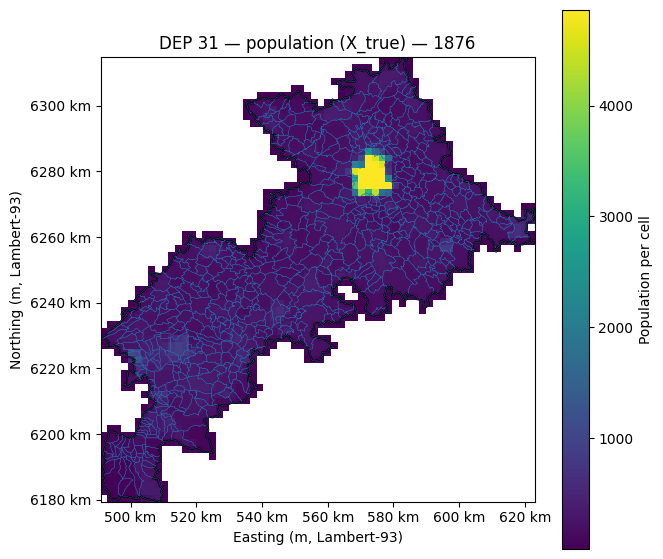

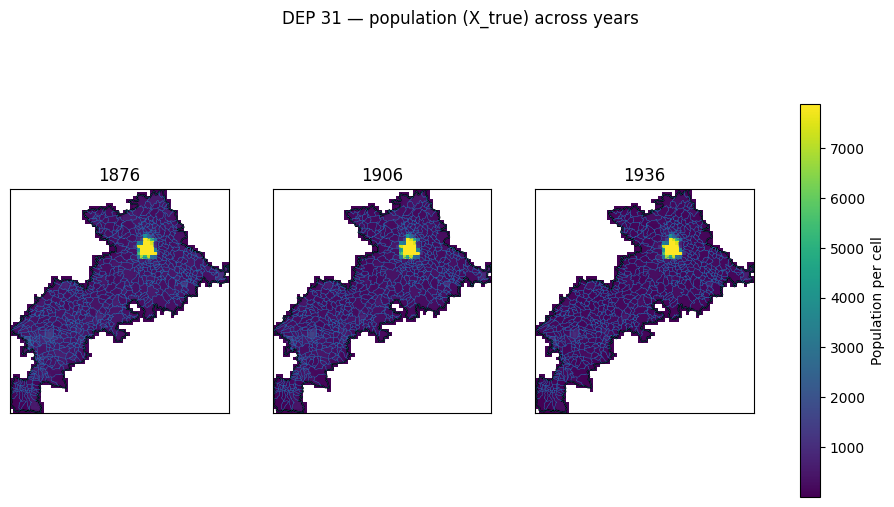

In [11]:
# Single year
_ = plot_dep_X_true(years[0], draw_communes=True)

# Small multiples
_ = compare_years([years[0], years[len(years)//2], years[-1]], draw_communes=True, ncols=3, figsize=(12,6))

## H. Optimal transport interpolation (mixed constraints)

We set up:
- **H1**: a spatial barrier that repeats at each time slice (forbidden outside the department).
- **H2**: a uniform “capacity” (ones) that lets the solver infer the evolving mass level.
- **F1**: zero (no explicit penalty associated with `H1` beyond feasibility).
- **F2**: the **mass budget** per time layer obtained by linear interpolation between yearly totals, then scaled per-cell area.

The solver interface used below mirrors your `proximal.dynamicUOT.computeGeodesic` function.  
Adjust the `sys.path.append(...)` to locate your `proximal/` package if needed.

In [12]:
# --- Mixed-constraint tensors ---
num_years = years.shape[0]
T = num_years - 1  # number of intervals (OT time steps)
barrier_float = barrier.astype(float)

H1 = np.stack([barrier_float] * T, axis=0)   # shape (T, N, N)
H2 = np.ones((T, barrier.shape[0], barrier.shape[1]), dtype=float)

F1 = np.zeros((T,), dtype=float)
# Linear interpolation of total mass, scaled to per-cell target (area ~ 1 in index units)
time_centered_grid = [(i + 0.5) / T for i in range(T)]
time_staggered_grid  = [i / T for i in range(T + 1)]
F2 = np.interp(time_centered_grid, time_staggered_grid, np.sum(X_true.reshape(num_years, -1), axis=1)) * (1/N) * (1/N)

H = [H1, H2]
F = [F1, F2]

rho_0 = X_true[0]
rho_1 = X_true[-1]

# --- Bring your solver into scope ---
import sys
sys.path.append('../')  # adjust if your `proximal/` lives elsewhere
try:
    from proximal.dynamicUOT import computeGeodesic
    HAVE_SOLVER = True
except Exception as e:
    HAVE_SOLVER = False
    print("[info] Could not import computeGeodesic from proximal.dynamicUOT.")
    print("       Please adjust sys.path above to point to your project.")
    print("       Error was:", repr(e))

# --- Run OT geodesic if available ---
if HAVE_SOLVER:
    ll = (1.0, 1.0, 1.0)  # size of time × space box
    X_ot, lists = computeGeodesic(rho_0, rho_1, T, ll, p=2.0, q=2.0, delta=1.0,
                                  H=H, F=F, niter=3000, big_matrix=True, verbose=True)
    np.savez_compressed(f"data/output/dep_{str(DEP_CODE).upper()}_Xot.npz", X_ot=X_ot)
    print("OT interpolation complete. Saved X_ot bundle.")
else:
    X_ot = None

Computing a geodesic for optimal transport with source and constraint...


c:\Users\mao17\Workspace\pdot\venv\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


Progress: 99%
Done.
OT interpolation complete. Saved X_ot bundle.


## I. Compare **X_true** vs **X_ot**

Helper functions to align OT time slices to requested **years** and plot side‑by‑side comparisons.

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def _true_idx(year, years):
    if year not in years.tolist():
        raise ValueError(f"Year {year} not in available list {years.tolist()}")
    return int(np.where(years == year)[0][0])

def _align_true_to_ot(i_true, T_true, T_ot):
    """Map X_true index (0..T_true-1) to closest OT index (0..T_ot-1)."""
    if T_true < 2:  # degenerate
        return 0
    return int(round(i_true * (T_ot - 1) / (T_true - 1)))

def plot_Xtrue_vs_Xot(year,
                      equalize_scale=True,
                      draw_communes=False,
                      vmax=None,
                      figsize=(12,6),
                      savepath=None):
    """
    Plot a single 'year' with X_true (left) and the aligned X_ot time slice (right).
    """
    if X_ot is None:
        raise RuntimeError("X_ot is not available. Run the OT cell (H) after importing your solver.")
    barrier_mask = barrier.astype(bool)

    i_true = _true_idx(year, years)
    T_true = X_true.shape[0]
    T_ot   = X_ot.shape[0]
    i_ot   = _align_true_to_ot(i_true, T_true, T_ot)

    # Prepare data (mask barriers, clip tiny negatives from OT if any)
    Z_true = np.ma.array(X_true[i_true], mask=barrier_mask)
    Z_ot   = np.ma.array(np.clip(X_ot[i_ot], 0, None), mask=barrier_mask)

    vmin = 0.0
    if vmax is None:
        if equalize_scale:
            both = np.r_[Z_true.compressed(), Z_ot.compressed()]
            vmax = np.percentile(both, 99) if both.size else 1.0
        else:
            vmax = np.percentile(Z_true.compressed(), 99) if Z_true.count() else 1.0

    fig, axes = plt.subplots(1, 2, figsize=figsize, constrained_layout=True)

    # Left: X_true
    pcm1 = axes[0].pcolormesh(x_edges, y_edges, Z_true, shading="auto", vmin=vmin, vmax=vmax)
    dep_boundary.plot(ax=axes[0], facecolor="none", linewidth=1.0)
    if draw_communes and (dep_communes_opt is not None):
        dep_communes_opt.boundary.plot(ax=axes[0], linewidth=0.25)
    axes[0].set_aspect("equal"); axes[0].set_title(f"X_true — {int(year)}")
    axes[0].set_xticks([]); axes[0].set_yticks([])

    # Right: X_ot (aligned step)
    pcm2 = axes[1].pcolormesh(x_edges, y_edges, Z_ot, shading="auto", vmin=vmin, vmax=(vmax if equalize_scale else np.percentile(Z_ot.compressed(), 99)))
    dep_boundary.plot(ax=axes[1], facecolor="none", linewidth=1.0)
    if draw_communes and (dep_communes_opt is not None):
        dep_communes_opt.boundary.plot(ax=axes[1], linewidth=0.25)
    axes[1].set_aspect("equal"); axes[1].set_title(f"X_ot — step {i_ot+1}/{T_ot} (aligned to {int(year)})")
    axes[1].set_xticks([]); axes[1].set_yticks([])

    # Shared colorbar
    cbar = fig.colorbar(pcm1, ax=axes.ravel().tolist(), shrink=0.9, label="Population per cell")

    if savepath:
        fig.savefig(savepath, dpi=200, bbox_inches="tight")
    plt.show()
    return fig

def compare_Xtrue_Xot_many(year_list,
                           equalize_scale=True,
                           draw_communes=False,
                           ncols=2,
                           figsize_per_row=3.5,
                           savepath=None):
    """
    Small multiples: for each year in 'year_list', draw X_true (left) and the aligned X_ot (right).
    """
    if X_ot is None:
        raise RuntimeError("X_ot is not available. Run the OT cell (H) after importing your solver.")

    barrier_mask = barrier.astype(bool)
    T_true, T_ot = X_true.shape[0], X_ot.shape[0]

    # Gather aligned slices
    pairs = []
    for yr in year_list:
        i_true = _true_idx(yr, years)
        i_ot = _align_true_to_ot(i_true, T_true, T_ot)
        Zt = np.ma.array(X_true[i_true], mask=barrier_mask)
        Zo = np.ma.array(np.clip(X_ot[i_ot], 0, None), mask=barrier_mask)
        pairs.append((yr, i_ot, Zt, Zo))

    # Global color scale if requested
    vmin = 0.0
    all_vals = np.concatenate([np.r_[Zt.compressed(), Zo.compressed()] for _,_,Zt,Zo in pairs]) if pairs else np.array([1.0])
    vmax = np.percentile(all_vals, 99) if (equalize_scale and all_vals.size) else None

    # Figure layout
    import math
    nrows = len(pairs)
    fig, axes = plt.subplots(nrows, 2, figsize=(2*figsize_per_row, max(1, nrows)*figsize_per_row), squeeze=False)

    last_pcm = None
    for r, (yr, i_ot, Zt, Zo) in enumerate(pairs):
        # X_true
        pcm = axes[r, 0].pcolormesh(x_edges, y_edges, Zt, shading="auto", vmin=vmin, vmax=(vmax if vmax is not None else np.percentile(Zt.compressed(), 99)))
        last_pcm = pcm
        dep_boundary.plot(ax=axes[r, 0], facecolor="none", linewidth=1.0)
        if draw_communes and (dep_communes_opt is not None):
            dep_communes_opt.boundary.plot(ax=axes[r, 0], linewidth=0.25)
        axes[r, 0].set_aspect("equal"); axes[r, 0].set_title(f"{int(yr)}"); axes[r, 0].set_xticks([]); axes[r, 0].set_yticks([])

        # X_ot
        pcm = axes[r, 1].pcolormesh(x_edges, y_edges, Zo, shading="auto", vmin=vmin, vmax=(vmax if vmax is not None else np.percentile(Zo.compressed(), 99)))
        last_pcm = pcm
        dep_boundary.plot(ax=axes[r, 1], facecolor="none", linewidth=1.0)
        if draw_communes and (dep_communes_opt is not None):
            dep_communes_opt.boundary.plot(ax=axes[r, 1], linewidth=0.25)
        axes[r, 1].set_aspect("equal"); axes[r, 1].set_title(f"OT step {i_ot+1}/{T_ot}"); axes[r, 1].set_xticks([]); axes[r, 1].set_yticks([])

    if last_pcm is not None:
        fig.colorbar(last_pcm, ax=axes.ravel().tolist(), shrink=0.9, label="Population per cell")

    fig.suptitle("X_true vs X_ot (aligned in time)", y=0.995)
    if savepath:
        fig.savefig(savepath, dpi=200, bbox_inches="tight")
    plt.show()
    return fig

### Paper-ready 2-row figure

In [14]:
from proximal.grids import CSvar
def figure_true_ot_2row(year_list,
                        equalize_scale=True,
                        robust_pct=99,
                        draw_communes=False,
                        cmap="viridis",
                        dep_lw=0.8,
                        com_lw=0.25,
                        width_per_col=3.0,
                        height_per_row=3.0,
                        panel_labels=False,
                        savepath=None,
                        dpi=300):
    """
    Build a paper-ready figure with two rows:
      Row 1: X_true for each year in `year_list` (columns)
      Row 2: X_ot aligned to those years (columns)
    One shared colorbar on the right.
    """
    global X_ot
    if X_ot is None:
        raise RuntimeError("X_ot is not available. Run the OT cell (H) after importing your solver.")
    if type(X_ot) == CSvar:
        X_ot = X_ot.U.D[0]

    # --- utilities ---
    def _idx_year(yr):
        if yr not in years.tolist():
            raise ValueError(f"Year {yr} not in available list {years.tolist()}")
        return int(np.where(years == yr)[0][0])

    def _align_true_to_ot(i_true, T_true, T_ot):
        if T_true < 2:
            return 0
        return int(round(i_true * (T_ot - 1) / (T_true - 1)))

    # --- checks ---
    assert X_ot.shape[1:] == X_true.shape[1:], "Grid size mismatch between X_true and X_ot"
    assert len(x_edges) == X_true.shape[2] + 1 and len(y_edges) == X_true.shape[1] + 1, "x_edges/y_edges mismatch"

    barrier_mask = barrier.astype(bool)
    T_true, T_ot = X_true.shape[0], X_ot.shape[0]

    # Gather slices and values for scaling
    Z_true_list, Z_ot_list, steps = [], [], []
    for yr in year_list:
        i_true = _idx_year(yr)
        i_ot   = _align_true_to_ot(i_true, T_true, T_ot)
        Zt = np.ma.array(X_true[i_true], mask=barrier_mask)
        Zo = np.ma.array(np.clip(X_ot[i_ot], 0, None), mask=barrier_mask)
        Z_true_list.append(Zt); Z_ot_list.append(Zo); steps.append(i_ot)

    # Robust color scale
    vmin = 0.0
    if equalize_scale:
        all_vals = np.concatenate([Z.compressed() for Z in (Z_true_list + Z_ot_list)]) if (Z_true_list or Z_ot_list) else np.array([1.0])
        vmax = np.percentile(all_vals, robust_pct) if all_vals.size else 1.0
    else:
        vmax_true = np.percentile(np.concatenate([Z.compressed() for Z in Z_true_list]), robust_pct)
        vmax_ot   = np.percentile(np.concatenate([Z.compressed() for Z in Z_ot_list]), robust_pct)
        vmax = max(vmax_true, vmax_ot)

    # Figure & axes (2 rows, C columns)
    C = len(year_list)
    fig_w = max(2.0, width_per_col * C)
    fig_h = max(2.0, height_per_row * 2)
    fig, axes = plt.subplots(2, C, figsize=(fig_w, fig_h), squeeze=False)

    # Layout
    fig.subplots_adjust(left=0.06, right=0.9, top=0.95, bottom=0.08, wspace=0.02, hspace=0.02)

    last_pcm = None
    # Row 1: X_true
    for c, (yr, Zt) in enumerate(zip(year_list, Z_true_list)):
        ax = axes[0, c]
        pcm = ax.pcolormesh(x_edges, y_edges, Zt, shading="auto", vmin=vmin, vmax=vmax, cmap=cmap)
        last_pcm = pcm
        dep_boundary.plot(ax=ax, facecolor="none", linewidth=dep_lw)
        if draw_communes and (dep_communes_opt is not None):
            dep_communes_opt.boundary.plot(ax=ax, linewidth=com_lw)
        ax.set_aspect("equal")
        ax.set_xticks([]); ax.set_yticks([])
        #ax.set_title(f"{int(yr)}", fontsize=14)

    # Row 2: X_ot
    for c, (Zo, i_ot) in enumerate(zip(Z_ot_list, steps)):
        ax = axes[1, c]
        pcm = ax.pcolormesh(x_edges, y_edges, Zo, shading="auto", vmin=vmin, vmax=vmax, cmap=cmap)
        last_pcm = pcm
        dep_boundary.plot(ax=ax, facecolor="none", linewidth=dep_lw)
        if draw_communes and (dep_communes_opt is not None):
            dep_communes_opt.boundary.plot(ax=ax, linewidth=com_lw)
        ax.set_aspect("equal")
        ax.set_xticks([]); ax.set_yticks([])

    # Shared colorbar
    if last_pcm is not None:
        pass
        #cax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
        #cb = fig.colorbar(last_pcm, cax=cax)
        #cb.set_label("Population per cell", fontsize=10)

    # Save if requested
    if savepath:
        ext = str(savepath).split(".")[-1].lower()
        if ext in ("pdf", "svg"):
            fig.savefig(savepath, bbox_inches="tight")
        else:
            fig.savefig(savepath, dpi=dpi, bbox_inches="tight")

    return fig, axes

### Example: generate a paper-ready panel

Saved figure to data/output/dep_31_true_vs_ot.png


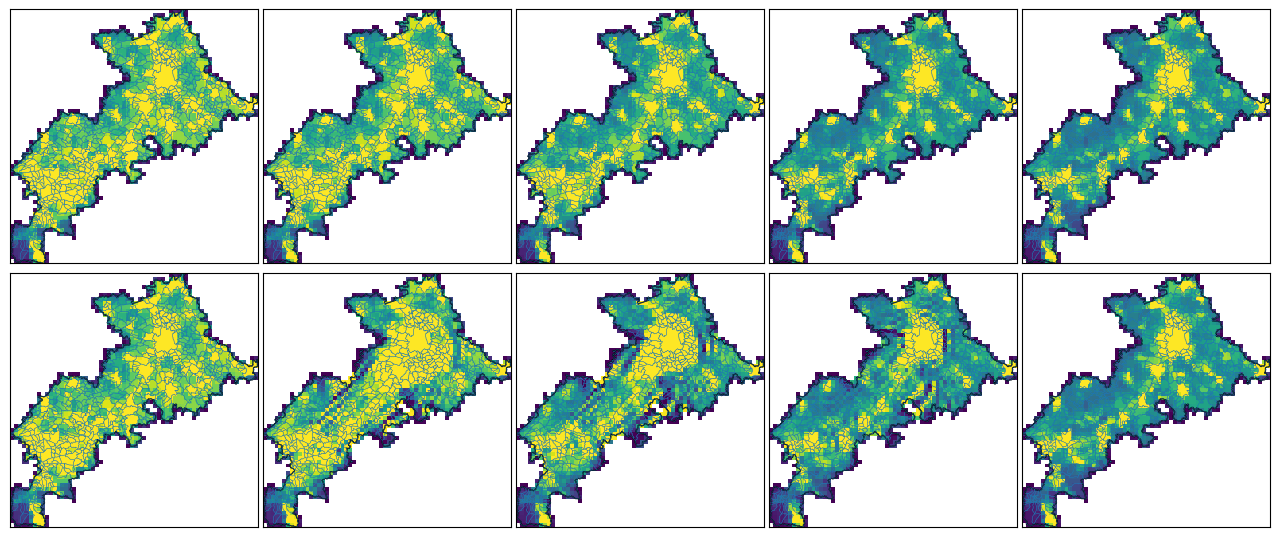

In [16]:
if 'X_ot' in globals() and X_ot is not None:
    # Example columns: first, a mid-sample, and last year
    cols = [1876, 1891, 1906, 1926, 1936]
    fig, axes = figure_true_ot_2row(cols, draw_communes=True, robust_pct=80,
                                    savepath=f"data/output/dep_{str(DEP_CODE).upper()}_true_vs_ot_pct80.png")
    print("Saved figure to", f"data/output/dep_{str(DEP_CODE).upper()}_true_vs_ot.png")
else:
    print("X_ot not available yet — run section H after importing your solver.")

## Appendix — Tips & Troubleshooting

- **Corsica**: Use `DEP_CODE="2A"` or `"2B"` for each department separately. Use `"20"` to aggregate both.
- **Rhône / Lyon (69)**: Some datasets use `69D` and `69M`. Using `DEP_CODE="69"` selects either form.
- **Missing columns**: If your Excel uses different headers, adjust the `dep_cols`, `cod_cols`, and `name_cols` lists.
- **Performance**: The overlap matrix scales with `N² × (#communes)`. Start at `N=64` and consider enabling SciPy.
- **CRS**: Everything is reprojected to `EPSG:2154` before spatial ops. Ensure your GPKG loads correctly.
- **OT solver import**: Adjust `sys.path.append(...)` so `from proximal.dynamicUOT import computeGeodesic` succeeds.